# An Analysis of Turkish Political Election Manifestos and Training A Text Classifier with Bert

In this notebook a text classifier was trained for turkish political election manifestos. The goal is to develop a machine learning model that can accurately predict text data into classes. The model is fine-tuned on a turkish bert model: BERTurk - BERT models for Turkish. https://github.com/stefan-it/turkish-bert

The dataset is created by turkish manifestos from 2002 to 2023 and three parties with diverse political positions (Right-wing, Centre-left to left-wing, and centre-left).

The dataset of manifesto sentences were labeled according to their parties and then tokenized with Bert tokenizer to obtain contexual tokens. These tokens were then passed through neural network layers to make predictions.

Parties in the dataset:
CHP (Republican People's Party)
AKP (Justice and Development Party)
HDP (People's Democratic Party)



### 1. Exploring and Preprocessing The Dataset



In [1]:
!pip install https://huggingface.co/turkish-nlp-suite/tr_core_news_md/resolve/main/tr_core_news_md-any-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.0/156.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.2
    Uninstalling wasabi-1.1.2:
      Successfully uninstalled wasabi-1.1.2
  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.4
    Uninstalling pydantic-2.6.4:
      Successfully uninstalled pydantic-2.6.4
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.3
    Uninstalling thinc-8.2.3:
      Successfully uninstalled t

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import spacy
from matplotlib import pyplot as plt
import datasets
from datasets import Dataset
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import nltk
from os import path
import torch.nn.functional as F
from wordcloud import WordCloud
from collections import Counter
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
nltk.download("stopwords")
nltk.download('punkt')
nlp = spacy.load("tr_core_news_md")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
data = pd.read_csv('merged_data.csv', encoding="UTF-8")

# Run summary/descriptive statistics tests on the data
print("Head of the dataframe:")
print(data.head())
print("\nDescriptive statistics of the dataframe:")
print(data.describe())

Head of the dataframe:
   Party_Code    Year                                               text
0       74321  200211                            GÜZEL GÜNLER GÖRECEĞİZ!
1       74321  200211      Cumhuriyet Halk Partisi 2002 Seçim Bildirgesi
2       74321  200211     Türkiye'den, “Tek Başına İktidar” İstiyoruz...
3       74321  200211                      Türkiye bir yol ayrımındadır.
4       74321  200211  3 Kasım'da Türkiye, ya ekonomik krizden çıkaca...

Descriptive statistics of the dataframe:
         Party_Code           Year
count  58435.000000   58435.000000
mean   74528.480363  186574.328639
std      182.640131   52154.950312
min    74210.000000    2007.000000
25%    74321.000000  201106.000000
50%    74628.000000  201506.000000
75%    74628.000000  201511.000000
max    74712.000000  202302.000000


In [5]:
# Erasing NaN values and rows with just one character, and looking at the number of rows per party.

missing_values = data.isnull().sum()
data.fillna("", inplace=True)

data = data[data['text'].str.len() >= 2]

party_counts = data['Party_Code'].value_counts()

for party, count in party_counts.items():
    print(f"Party {party} has {count} rows.")

Party 74628 has 23320 rows.
Party 74321 has 14909 rows.
Party 74712 has 14351 rows.
Party 74210 has 5837 rows.


Party 74628 has 23320 rows.
Party 74321 has 14909 rows.
Party 74712 has 14351 rows.
Party 74210 has 5837 rows.

I will create a new dataset with three parties where each party has 5837. I am dropping the "Nationalist Movement Party" as I realized the sentences are similar to "Justice and Development Party".

In [6]:
# Mapping the party names and labels
party_names = {
    74628 : "Justice and Development Party",
    74321 : "Republican People's Party",
    74712 : "Nationalist Movement Party",
    74210 : "Peoples' Democratic Party"
}

labels = {
    74628 : 0,
    74321 : 1,
    74210 : 2,
    74712 : 3,
}

In [7]:
# Creating a dataset of 3 parties.
# Dropping some rows to make all the data more or less equal between parties.

data_3 = data[data['Party_Code'] != 74712]
data_3_parties = pd.DataFrame(columns=data_3.columns)

for party, group in data_3.groupby('Party_Code'):
    rows = group.sample(5837, random_state=50)
    data_3_parties = pd.concat([data_3_parties, rows])

data_3_parties['Party_Name'] = data_3_parties['Party_Code'].map(party_names)
data_3_parties['label'] = data_3_parties['Party_Code'].map(labels)

In [8]:
class Preprocess:
  def __init__(self, dataframe):
    self.dataframe = dataframe

  @staticmethod
  def lower(text):
    """
    Function to lowercase the text and remove non turkish alphabet characters including numbers.
    """
    text = text.lower()
    text = re.sub("[^aâbcçdefgğhıijklmnoöprsştuüvyz]"," ",text)
    text = nltk.word_tokenize(text)
    text=" ".join(text)
    return text

  @staticmethod
  def lemmatizer(text):
    """
    Function to lemmatize the text.
    """
    lemma_text_list = []
    for doc in nlp.pipe(text, batch_size=128, n_process=3, disable=["parser", "ner"]):
        lemma_text_list.append(" ".join(token.lemma_ for token in doc))
    return lemma_text_list

  @staticmethod
  def remove_stopwords(text):
    """
    Function to remove stopwords and strings shorter than 2 chars.
    """
    text = [word for word in text.split() if word not in set(stopwords.words("turkish")) and len(word) >= 2]
    return " ".join(text)

  def process(self):
    # I realized the lemmatization process sometimes adds capitalized letters
    # and these may have problems. eg. The capitalized İ does not go to i when .lower()
    # is used but rather to a specialized character. So I remove them.
    self.dataframe["text"] = self.dataframe["text"].apply(self.lower)
    self.dataframe["text_lemma"] = self.lemmatizer(self.dataframe["text"])
    self.dataframe["clean"] = self.dataframe["text_lemma"].apply(self.remove_stopwords)
    self.dataframe["clean"] = self.dataframe["clean"].apply(self.lower)

In [9]:
preprocessor = Preprocess(data_3_parties)
preprocessor.process()

In [10]:
data_3_parties

,Party_Code,Year,text,Party_Name,label,text_lemma,clean
51239,74210,2023,ve devam eden savaş ve çatışma nedeniyle yerle...,Peoples' Democratic Party,2,ve devam et savaş ve çatış neden yerleşim yeri...,devam et savaş çatış yerleşim yerinden göç et ...
47139,74210,202302,kadın katilleri ellerini kollarını sallayarak ...,Peoples' Democratic Party,2,kadın katil el kol salla sokak gezer,kadın katil el kol salla sokak gezer
6752,74210,2014,kadınların ücretli emeği ise ev içi rollerle u...,Peoples' Democratic Party,2,kadınların ücret emek i ev iç rol uyum ve düşü...,kadınların ücret emek ev iç rol uyum düşük ücr...
40564,74210,201806,nitelikten tamamen uzak bir şekilde her kente ...,Peoples' Democratic Party,2,nitelikten tamamen uzak bir şekil her kent bir...,nitelikten tamamen uzak bir şekil kent bir üni...
50305,74210,2023,e şiddet çocuk istismarı ırkçılık ayrımcılık h...,Peoples' Democratic Party,2,e şiddet çocuk istismar ırkçı ayrımcı hal varl...,şiddet çocuk istismar ırkçı ayrımcı hal varlık...
...,...,...,...,...,...,...,...
31766,74628,201506,türkiye ve i spanya nın öncülüğünde yılında ba...,Justice and Development Party,0,türkiye ve İ spanya nın öncülüğünde yıl başlat...,türkiye spanya nın öncülüğünde yıl başlat mede...
11490,74628,201806,b neler yapacağız,Justice and Development Party,0,b ne yap,yap
28627,74628,201506,önümüzdeki dönemde başta eğitimin kalitesini y...,Justice and Development Party,0,ön dönem baş eğitim kalitesini yükselt ol üzer...,ön dönem baş eğitim kalitesini yükselt ol üzer...
36004,74628,201106,diğer önemli bir değişim alanı ise kamu yöneti...,Justice and Development Party,0,diğer önem bir değişim alan i kamu yönetici tu...,diğer önem bir değişim alan kamu yönetici tutu...


### 2. Semantic Analysis of the Manifestos

I wanted to do word clouds to see the most commonly words used in the party manifestos. The results show that overall they use similar words such as politics, project, economy. However some differences can also be seen such as HDP that is defending minority rights use words like "struggle" and "exploitation". AKP, which is the nationalistic party uses the word "country" and "nation" more whereas CHP emphasizes "world" and "region". These clues may. help the model distinguish these parties better.

In [11]:
def most_common(dataframe):

  common_words = {}

  for party in dataframe["Party_Name"].unique():

    words = (' '.join(dataframe[dataframe['Party_Name'] == party]['clean'])).split()

    counts = Counter(words)
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    common_words[party] = [word for word, count in sorted_counts]


  for party in common_words:

    wordcloud = WordCloud(width = 1500, height = 1000,
                background_color ='black',
                min_font_size = 10).generate(" ".join(common_words[party]))

    plt.figure(figsize = (3, 3), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f"Most Common Words by {party}")

  plt.tight_layout()
  plt.show()

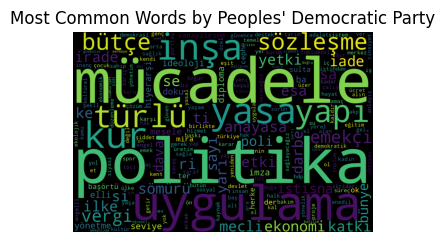

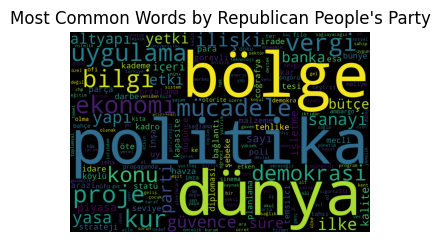

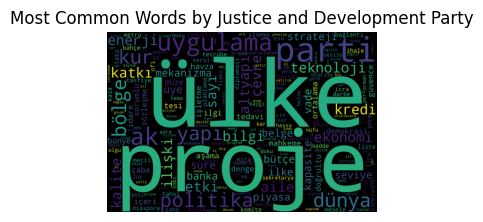

In [12]:
party_word_lists = most_common(data_3_parties)
party_word_lists

### 3. Creating Dataloaders

It is time to create dataloaders to be used in the neural network model. For this I split the dataframe into test and training data and check their balance. I also add a mini dataset to run the model faster and play with more hyperparameters.

In [13]:
data_3_parties.reset_index(drop=True, inplace=True)
df_label_sent = data_3_parties[["clean", "label"]]

In [14]:
mini_train, mini_test = train_test_split(df_label_sent, train_size=1/40, test_size=1/80, random_state=42, shuffle=True)
mini_train.reset_index(drop=True, inplace=True)
mini_test.reset_index(drop=True, inplace=True)

train_df, test_df = train_test_split(df_label_sent, test_size=0.2, random_state=42, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [15]:
for i in range(3):
  print(len(train_df[train_df['label'] == i]))

4702
4623
4683


In [16]:
for i in range(3):
  print(len(test_df[train_df['label'] == i]))

1185
1152
1166


In [17]:
for i in range(3):
  print(len(mini_train[mini_train['label'] == i]))

130
157
150


In [18]:
for i in range(3):
  print(len(mini_test[mini_test['label'] == i]))

69
79
71


In [19]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

In [20]:
class MyDataset(Dataset):
  """
  Creating a custom dataset with torch.utils.
  """

  def __init__(self, dataframe, tokenizer):

      self.dataframe = dataframe
      self.tokenizer = tokenizer
      self.max_length = 512 # As the pre-trained bert model requires the mac length to be 512.

  def __len__(self):

      return len(self.dataframe)

  def __getitem__(self, index):

      text = self.dataframe.at[index, "clean"]
      label = self.dataframe.at[index, "label"]
      encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding="max_length", truncation=True)
      # Tokenizing the dataset with padding and truncaiton so that the sizes are the same.

      input_ids = encoding['input_ids'].squeeze()
      attention_mask = encoding['attention_mask'].squeeze()

      labels = torch.zeros(3)
      labels[label] = 1
      return { "input_ids": input_ids,
               "attention_mask": attention_mask,
               "labels": labels
        }

In [21]:
batch_size = 64
mini_train_dataset = MyDataset(mini_train, tokenizer)
mini_test_dataset = MyDataset(mini_test, tokenizer)
mini_train_dataloader = DataLoader(mini_train_dataset, batch_size=batch_size, shuffle=True)
mini_test_dataloader = DataLoader(mini_test_dataset, batch_size=batch_size)

In [22]:
batch_size = 64
train_dataset = MyDataset(train_df, tokenizer)
test_dataset = MyDataset(test_df, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [23]:
# Checking the shape and size of the dataloader.
for batch in mini_test_dataloader:
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    print("Input IDs shape:", input_ids.shape)
    print("Attention mask shape:", attention_mask.shape)
    print("Labels shape:", labels.shape)

Input IDs shape: torch.Size([64, 512])
Attention mask shape: torch.Size([64, 512])
Labels shape: torch.Size([64, 3])
Input IDs shape: torch.Size([64, 512])
Attention mask shape: torch.Size([64, 512])
Labels shape: torch.Size([64, 3])
Input IDs shape: torch.Size([64, 512])
Attention mask shape: torch.Size([64, 512])
Labels shape: torch.Size([64, 3])
Input IDs shape: torch.Size([27, 512])
Attention mask shape: torch.Size([27, 512])
Labels shape: torch.Size([27, 3])


### 4. Training A Bert Based Classifier for Political Manifestos Using Neural Networks

In [ ]:
!pip install wandb
import wandb

wandb.login()

In [40]:
"""
Fine-tuning the Bert model for the classification task.
Can work with GPUs. The code without GPU alternative has been commented out.
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")

class ClassifierTurkish(torch.nn.Module):

      def __init__(self, hidden_state_size, device="cuda"):
      #def __init__(self, hidden_state_size):
        super(ClassifierTurkish, self).__init__()
        self.device = device
        self.bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

        """A three layer neural network model with initial size 768 (due to
        pretrained BERT architecture and its requirements)
        and output size 3 due to 3 classes in the dataset."""

        self.layers = nn.Sequential(
            nn.Linear(768, hidden_state_size),
            nn.ReLU(),
            nn.Linear(hidden_state_size, hidden_state_size),
            nn.ReLU(),
            nn.Linear(hidden_state_size, 3)
        )

        # Freezing the parameters.
        for param in self.bert.parameters():
          param.requires_grad = False

      def forward(self, input_ids, attention_mask):
        """Forward function that takes input_ids and attention_mask and passes to
         BERT providing contextualized representations for each token. Then the
         tokens go through the layers of the model calculating the predictions, logits."""

        input_ids, attention_mask = input_ids.to(self.device), attention_mask.to(self.device)
        #input_ids, attention_mask = input_ids, attention_mask

        bert_forward = self.bert(input_ids, attention_mask)
        last_hidden_states = bert_forward.last_hidden_state
        logits = self.layers(last_hidden_states)

        return logits

      def accuracy(self, pred, gold):
        """ Accuracy function to calculate the accuracy level of the predicitons vs gold labels."""

        total = 0
        correct = 0

        for predicted_tags, gold_tags in zip(pred, gold):

            for p, g in zip(predicted_tags, gold_tags):
              if g == 0:
                pass
              else:
                total += 1
                if g == p:
                  correct += 1

        return correct, total

      def train_model(self, dataloader, validation, learning_rate=0.01, num_epoch=100, device="cuda"):
        """ Training model where input data is takne and it is being passed thorugh forward functions
        where the output is predicted. Then the predictions are compared gold outputs to get the
        accuracy percentage."""
      #def train_model(self, dataloader, validation, learning_rate=0.01, num_epoch=100):
        self.to(device)
        loss_function = nn.CrossEntropyLoss() # Loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate) # Optimizer

        for epoch in range(num_epoch):
            # Starting the train mode for the model.
            self.train()
            correct = 0
            total = 0
            loss_per_epoch = 0

            for batch in dataloader:
                # Iterating through the batches and making predicitons at each epoch.

                inputs = batch["input_ids"]
                gold_outputs = batch["labels"].long()
                attention = batch["attention_mask"]

                predicted_logits = self.forward(inputs, attention)
                # Calculating the loss score after each epoch.
                batch_loss = loss_function(predicted_logits.to(device), gold_outputs.to(device))
                #batch_loss = loss_function(predicted_logits, gold_outputs)

                loss_per_epoch += batch_loss.sum().item()

                label_ids = torch.max(predicted_logits, dim=2).indices
                c, t = self.accuracy(label_ids, gold_outputs)

                correct += c
                total += t

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            accuracy_on_train = correct/total
            wandb.log({"epoch" : epoch, "train_accuracy" : accuracy_on_train, "loss" : loss_per_epoch})
            print(f"Epoch: {epoch}\nLoss: {loss_per_epoch}   ---  Accuracy on train: {accuracy_on_train}")


            correct = 0
            total = 0

            with torch.no_grad():
              # Starting the evaluation mode for the model.
              self.eval()

              for batch in validation:
                # Iterating through the validaiton set to get the accuracy at the time.

                #inputs = batch["input_ids"]
                #attention_mask = batch["attention_mask"]
                #gold_outputs = batch["labels"]
                inputs = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                gold_outputs = batch["labels"].to(self.device)

                predicted_logits = self.forward(inputs, attention_mask)
                label_ids = torch.max(predicted_logits, dim=2).indices
                c, t = self.accuracy(label_ids, gold_outputs)
                correct += c
                total += t

              val_accuracy = correct/total

              wandb.log({"accuracy" : val_accuracy})
              print(f"Accuracy on validation: {val_accuracy}")


In [37]:
model = ClassifierTurkish(128)

In [ ]:
# For mini-data.
run = wandb.init(
    project="my-coli-final-project"
)

In [ ]:
# For full data.
run = wandb.init(
    project="my-coli-final-project2"
)

In [39]:
model.train_model(train_dataloader, test_dataloader, learning_rate=0.001, num_epoch=5)

Epoch: 0
Loss: 218.8221543431282   ---  Accuracy on train: 0.05839520274129069
Accuracy on validation: 0.0659434770196974
Epoch: 1
Loss: 124.53526991605759   ---  Accuracy on train: 0.1403483723586522
Accuracy on validation: 0.16043391378818156
Epoch: 2
Loss: 114.59658634662628   ---  Accuracy on train: 0.1760422615648201
Accuracy on validation: 0.27662003996574364
Epoch: 3
Loss: 108.93470048904419   ---  Accuracy on train: 0.2859080525414049
Accuracy on validation: 0.2911789894376249
Epoch: 4
Loss: 104.79802015423775   ---  Accuracy on train: 0.306753283837807
Accuracy on validation: 0.43648301455894944


In [35]:
model.train_model(mini_train_dataloader, mini_test_dataloader, learning_rate=0.001, num_epoch=50)

Epoch: 0
Loss: 1.1264410391449928   ---  Accuracy on train: 0.7116704805491991
Accuracy on validation: 0.684931506849315
Epoch: 1
Loss: 0.938197985291481   ---  Accuracy on train: 0.6956521739130435
Accuracy on validation: 0.4977168949771689
Epoch: 2
Loss: 0.8540538772940636   ---  Accuracy on train: 0.6567505720823799
Accuracy on validation: 0.6621004566210046
Epoch: 3
Loss: 0.7989419400691986   ---  Accuracy on train: 0.7185354691075515
Accuracy on validation: 0.6484018264840182
Epoch: 4
Loss: 0.9051915891468525   ---  Accuracy on train: 0.7665903890160183
Accuracy on validation: 0.7168949771689498
Epoch: 5
Loss: 0.6191368736326694   ---  Accuracy on train: 0.7734553775743707
Accuracy on validation: 0.7031963470319634
Epoch: 6
Loss: 0.8283756524324417   ---  Accuracy on train: 0.7528604118993135
Accuracy on validation: 0.7351598173515982
Epoch: 7
Loss: 0.7716189250349998   ---  Accuracy on train: 0.8054919908466819
Accuracy on validation: 0.7031963470319634
Epoch: 8
Loss: 0.684244416